In [1]:
%matplotlib inline

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from itertools import product
import collections
import math
import random
import matplotlib.pyplot as plt
import numpy as np

from utils import ModelTrainer
from datasets import avGFPDataset, GB1Dataset, SGEMMDataset, EntacmaeaDataset

In [2]:
class FCN(nn.Module):
    def __init__(self, n, multiplier=2, batch_norm=False):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.fc4 = nn.Linear(n, 1)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(multiplier*n)
            self.bn2 = nn.BatchNorm1d(multiplier*n)
            self.bn3 = nn.BatchNorm1d(n)

    def forward(self, x):
        if self.batch_norm:
            x = self.bn1(F.leaky_relu(self.fc1(x)))
            x = self.bn2(F.leaky_relu(self.fc2(x)))
            x = self.bn3(F.leaky_relu(self.fc3(x)))
            x = self.fc4(x)
        else:
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            x = F.leaky_relu(self.fc3(x))
            x = self.fc4(x)

        return x.reshape(-1)

Loaded dataset from cache.
Loading SPRIGHT samples from cache ...
#0 - Train Loss: 1.066, R2: 0.069	Validation Loss: 0.893, R2: 0.103
#1 - Train Loss: 0.825, R2: 0.280	Validation Loss: 0.711, R2: 0.286
#2 - Train Loss: 0.563, R2: 0.508	Validation Loss: 0.525, R2: 0.472
#3 - Train Loss: 0.389, R2: 0.661	Validation Loss: 0.517, R2: 0.480
#4 - Train Loss: 0.332, R2: 0.710	Validation Loss: 0.380, R2: 0.619
#5 - Train Loss: 0.250, R2: 0.781	Validation Loss: 0.344, R2: 0.654
#6 - Train Loss: 0.206, R2: 0.820	Validation Loss: 0.304, R2: 0.694
#7 - Train Loss: 0.152, R2: 0.868	Validation Loss: 0.254, R2: 0.745
#8 - Train Loss: 0.126, R2: 0.890	Validation Loss: 0.240, R2: 0.759
#9 - Train Loss: 0.105, R2: 0.909	Validation Loss: 0.252, R2: 0.747
#10 - Train Loss: 0.099, R2: 0.914	Validation Loss: 0.221, R2: 0.778
#11 - Train Loss: 0.101, R2: 0.912	Validation Loss: 0.239, R2: 0.760
#12 - Train Loss: 0.096, R2: 0.916	Validation Loss: 0.205, R2: 0.794
#13 - Train Loss: 0.077, R2: 0.933	Validation L

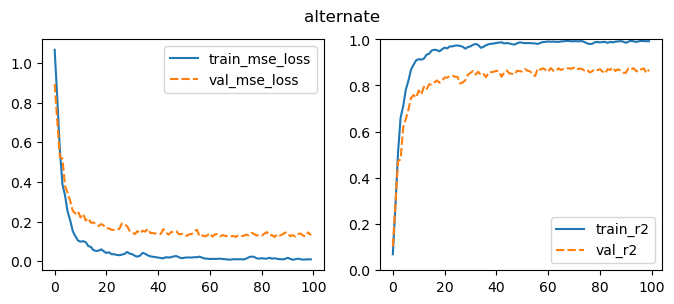

In [16]:
fix_seed = 1
random_seed = 11
dataset = "Entacmaea"

train_size = 50

config = {
    "training_method": "hashing",
    "b": 6,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 0.001,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
}

# config = {
#     "training_method": "normal",
#     "lr": 0.01, 
#     "weight_decay": 0, 
#     "num_epochs": 100,
#     "random_seed": random_seed,
#     "fix_seed": fix_seed,
#     "train_size": train_size,
#     "batch_size": 16,
#     "dataset": dataset,
#     "normalize": True
# }

config = {
    "training_method": "EN-S",
    "SPRIGHT_d": 3,
    "rho": 0.01,
    "b": 5,
    "lr": 0.01, 
    "weight_decay": 0, 
    "hadamard_lambda": 1,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "batch_size": 16,
    "dataset": dataset,
    "normalize": True
}

config = {
    "training_method": "alternate",
    "b": 7,
    "lr": 0.01, 
    "SPRIGHT_d": 3,
    "weight_decay": 0, 
    "hadamard_lambda": 0.1,
    "num_epochs": 100,
    "random_seed": random_seed,
    "fix_seed": fix_seed,
    "train_size": train_size,
    "dataset": dataset,
    "batch_size": 16,
    "normalize": True,
}

    
# Dataset
torch.manual_seed(config["fix_seed"])
if dataset == "GB1":
    dataset = GB1Dataset()
elif dataset == "avGFP":
    dataset = avGFPDataset()
elif dataset == "SGEMM":
    dataset = SGEMMDataset()
elif dataset == "Entacmaea":
    dataset = EntacmaeaDataset()
else:
    raise Exception
    
if config.get("normalize", False):
    dataset.y = (dataset.y-torch.mean(dataset.y))/torch.std(dataset.y)
dataset_size = len(dataset)
train_ds, val_ds = torch.utils.data.random_split(dataset, [config["train_size"], dataset_size - config["train_size"]])

# Train model
torch.manual_seed(config["random_seed"]) # Seed for network initialization
in_dim = dataset.X.shape[1]
model = FCN(in_dim, 1, batch_norm=False)
trainer = ModelTrainer(model, train_ds, val_ds, config=config,  plot_results=True, checkpoint_cache=True)
model = trainer.train_model()
print(max([l["val_r2"] for l in trainer.logs]))


In [6]:
dataset.X.shape

torch.Size([241600, 34])